In [1]:
import re
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import cellrank as cr
from scipy import sparse
from anndata import AnnData
import matplotlib.cm as cm
import os

sc.set_figure_params(dpi=100, color_map='viridis', fontsize=6)
sc.settings.verbosity=2
sc.settings.n_jobs=16
cr.settings.verbosity = 2
scv.settings.verbosity = 3
sc.logging.print_versions()

stype = "CD4"
oDir = os.path.abspath("./OUT_Fig3")

if not os.path.exists(oDir):
    os.makedirs(oDir)
os.chdir(oDir)

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.1.0
cellrank            1.1.0
cffi                1.12.3
colorama            0.4.1
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.0
decorator           4.4.0
docrep              0.3.1
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
igraph              0.7.1
importlib_metadata  0.17
ipykernel           5.1.1
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.13.3
joblib              0.13.2
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.7.0
llvmlite            0.35.0
louvain             0.6.1
matplotlib          3.4.1
mpl_toolkits        NA
natsort             6.0.0
numba               0.52.0
numexpr             2.6.9
numpy               1.19.5
packaging           19.0
pandas              1.1.5
parso               0.4.0
pexpect 

In [2]:
adata = sc.read(f"{oDir}/../../data/velo/adata_mini_{stype}.h5ad")

In [3]:
## add cellInfo
cellInfo = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}.miniInfo.txt.gz", compression='gzip', sep="\t", header=0, index_col=0)
cellInfo = cellInfo.loc[list(adata.obs_names), [not bool(re.match('RNA_', i)) for i in cellInfo.columns] ]
adata.obs = cellInfo
#
adata.obs['cancerType'] = [re.sub('\\..*', '', i) for i in np.array(adata.obs.dataset)]

In [4]:
## subset
flag = [i in ['CD4.c16.Tfh.CXCR5','CD4.c17.TfhTh1.CXCL13'] for i in adata.obs.loc[:,'meta.cluster']]
adata = adata[flag,]

In [5]:
## add embedding
redim1 = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}_Tfh.diffMap.txt.gz", compression="gzip", sep="\t", header=0, index_col=0)
redim2 = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}.umap_harmony.txt.gz", compression="gzip", sep="\t", header=0, index_col=0)
over = list(set(redim1.index) & set(redim2.index) & set(adata.obs_names))
adata=adata[over,]
redim1 = redim1.loc[over,:]
redim2 = redim2.loc[over,:]
redim1 = redim1.iloc[:,1:]  ## diffmap 0-col is non-informative
#
adata.obsm['X_DiffMap'] = np.array(redim1)
adata.obsm['X_UMAP'] = np.array(redim2) 

In [6]:
## add pseudotime
pseudotime = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}_Tfh.monocle3_pseudotime.txt.gz",
                       compression="gzip", sep="\t", header=0, index_col=0)
over = list(set(pseudotime.index) & set(adata.obs_names))
pseudotime = pseudotime.loc[over, ]
adata = adata[over,]
adata.obs['Monocle3_pseudotime'] = pseudotime.pseudotime

Trying to set attribute `.obs` of view, copying.


# scVelo

In [7]:
scv.pp.filter_and_normalize(adata, min_shared_cells=30, log=True)

Filtered out 26756 genes that are detected in less than 30 cells (shared).
Logarithmized X.


In [8]:
adata.X.shape

(282, 6938)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:00)
computing score 'G2M_score'
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


... storing 'dataset' as categorical
... storing 'dataset.tech' as categorical
... storing 'meta.cluster' as categorical
... storing 'cancerType' as categorical
... storing 'phase' as categorical


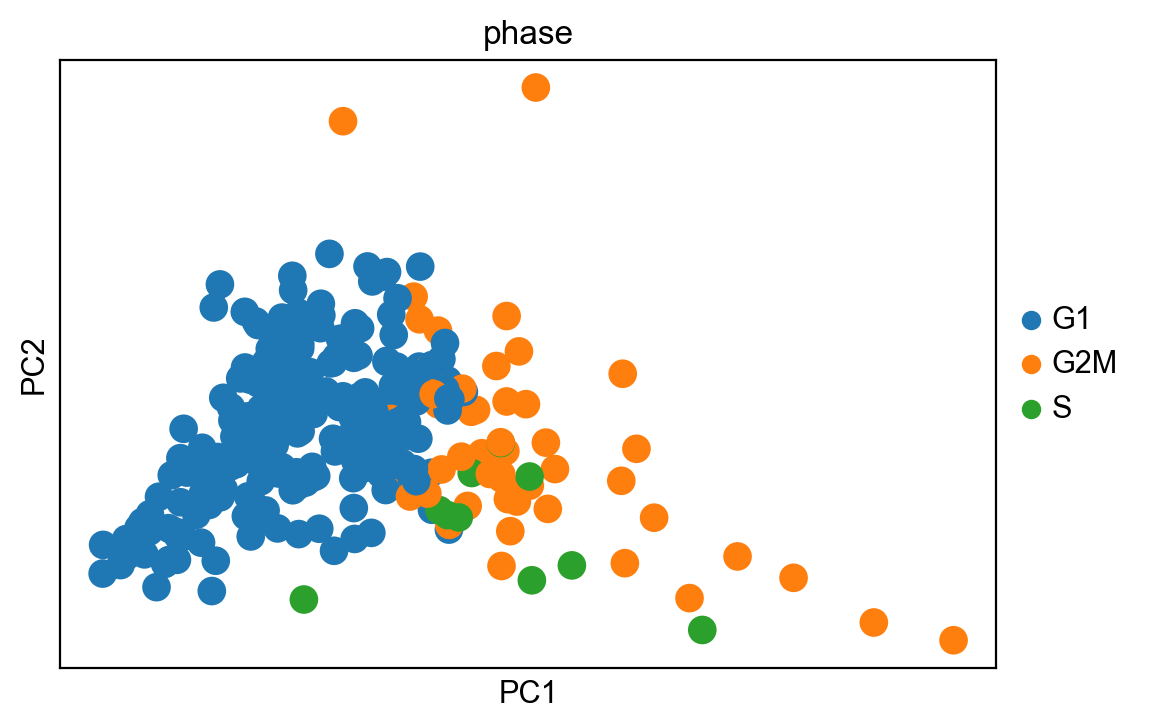

regressing out ['S_score', 'G2M_score']
    sparse input is densified and may lead to high memory use


... storing 'dataset' as categorical
... storing 'dataset.tech' as categorical
... storing 'meta.cluster' as categorical
... storing 'cancerType' as categorical
... storing 'phase' as categorical


    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:00)


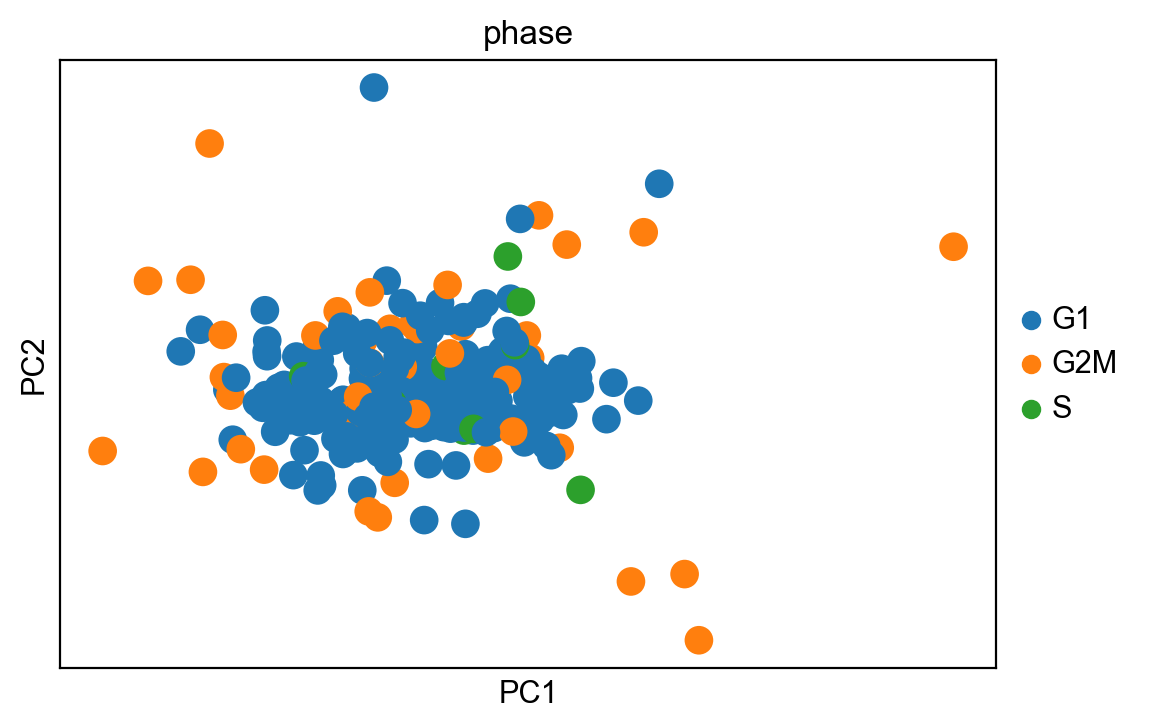

In [9]:
## read cycling genes
cell_cycle_genes = [x.strip() for x in open(f"{oDir}/../../data/external/regev_lab_cell_cycle_genes.txt")]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

## compute score
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

#plot
scv.settings.set_figure_params('scvelo', dpi=100)
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

## regress and scale
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

#plot
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [10]:
## clean some genes
ignoreGenes = pd.read_csv(f"{oDir}/../../data/external/all.gene.ignore.df.txt.gz", compression='gzip', sep="\t", header=0, index_col=0)
print(ignoreGenes.head())
flag = [not i in list(ignoreGenes['geneSymbol']) for i in list(adata.var.index)]
adata = adata[:,flag]
#
flag = [not bool(re.match('^RP[LS]', i)) for i in adata.var_names]
adata = adata[:,flag]

                 geneSymbol attr.chr     attr.beg     attr.end attr.strand  \
geneID                                                                       
ENSG00000143061       IGSF3        1  116574399.0  116667755.0           -   
ENSG00000276674  IGKV1OR1-1        1  144085628.0  144086098.0           +   
ENSG00000085552       IGSF9        1  159927039.0  159945604.0           -   
ENSG00000162729       IGSF8        1  160091340.0  160098943.0           -   
ENSG00000163395       IGFN1        1  201190825.0  201228952.0           +   

                        geneType display.name      seu.id  
geneID                                                     
ENSG00000143061   protein_coding        IGSF3       IGSF3  
ENSG00000276674  IG_V_pseudogene   IGKV1OR1-1  IGKV1OR1-1  
ENSG00000085552   protein_coding        IGSF9       IGSF9  
ENSG00000162729   protein_coding        IGSF8       IGSF8  
ENSG00000163395   protein_coding        IGFN1       IGFN1  


In [11]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing PCA
    with n_comps=30
    finished (0:00:00)
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [12]:
scv.tl.recover_dynamics(adata, n_jobs=32)
scv.tl.velocity(adata, mode='dynamical', min_r2=None)
scv.tl.velocity_graph(adata)

recovering dynamics (using 32/64 cores)



    finished (0:00:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_DiffMap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_.CD4_Tfh.pdf


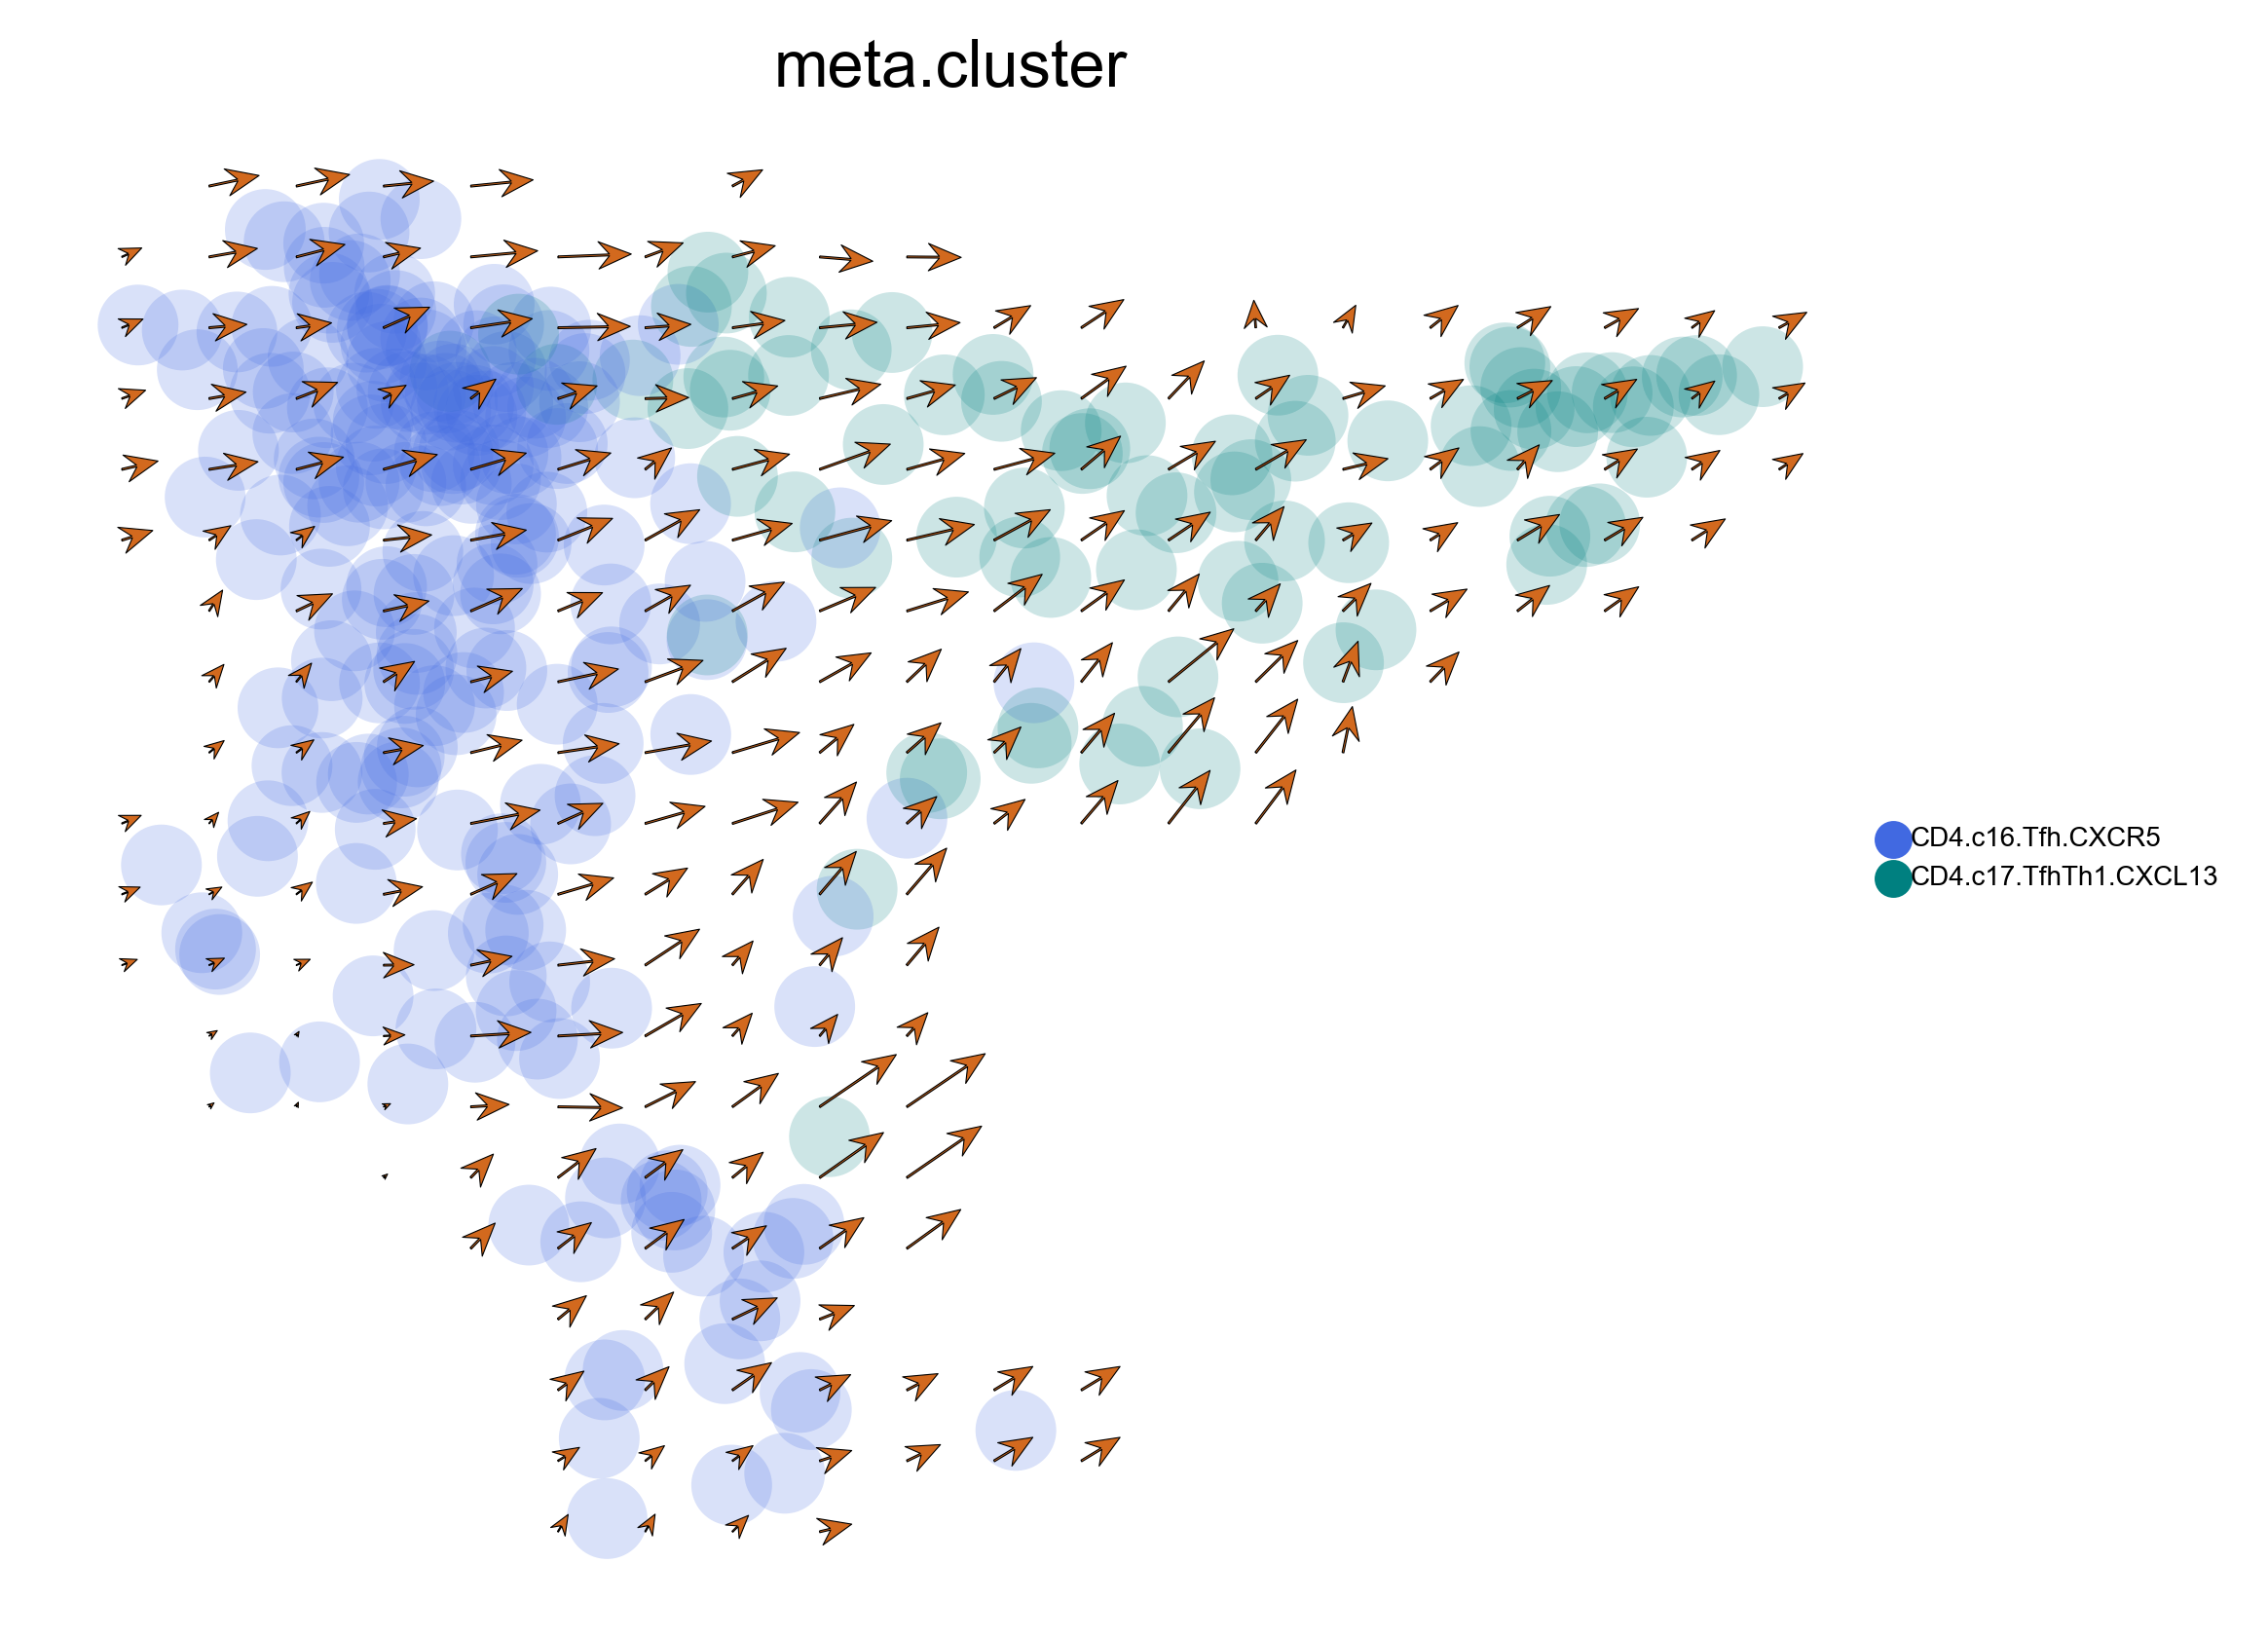

In [13]:
scv.settings.set_figure_params('scvelo', dpi=200)
adata.uns['meta.cluster_colors'] = ['#4169E1','#008080']
scv.pl.velocity_embedding_grid(adata, basis='DiffMap',color='meta.cluster',arrow_size=3, arrow_length=3,
                               density=0.4, arrow_color="#D2691E",
                               legend_loc='right margin',legend_fontsize=5, #palette="Set1",
                               save=f".{stype}_Tfh.pdf", figsize=(6,5),
                              )

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_UMAP', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_.CD4_Tfh.FigureS25.umap.pdf


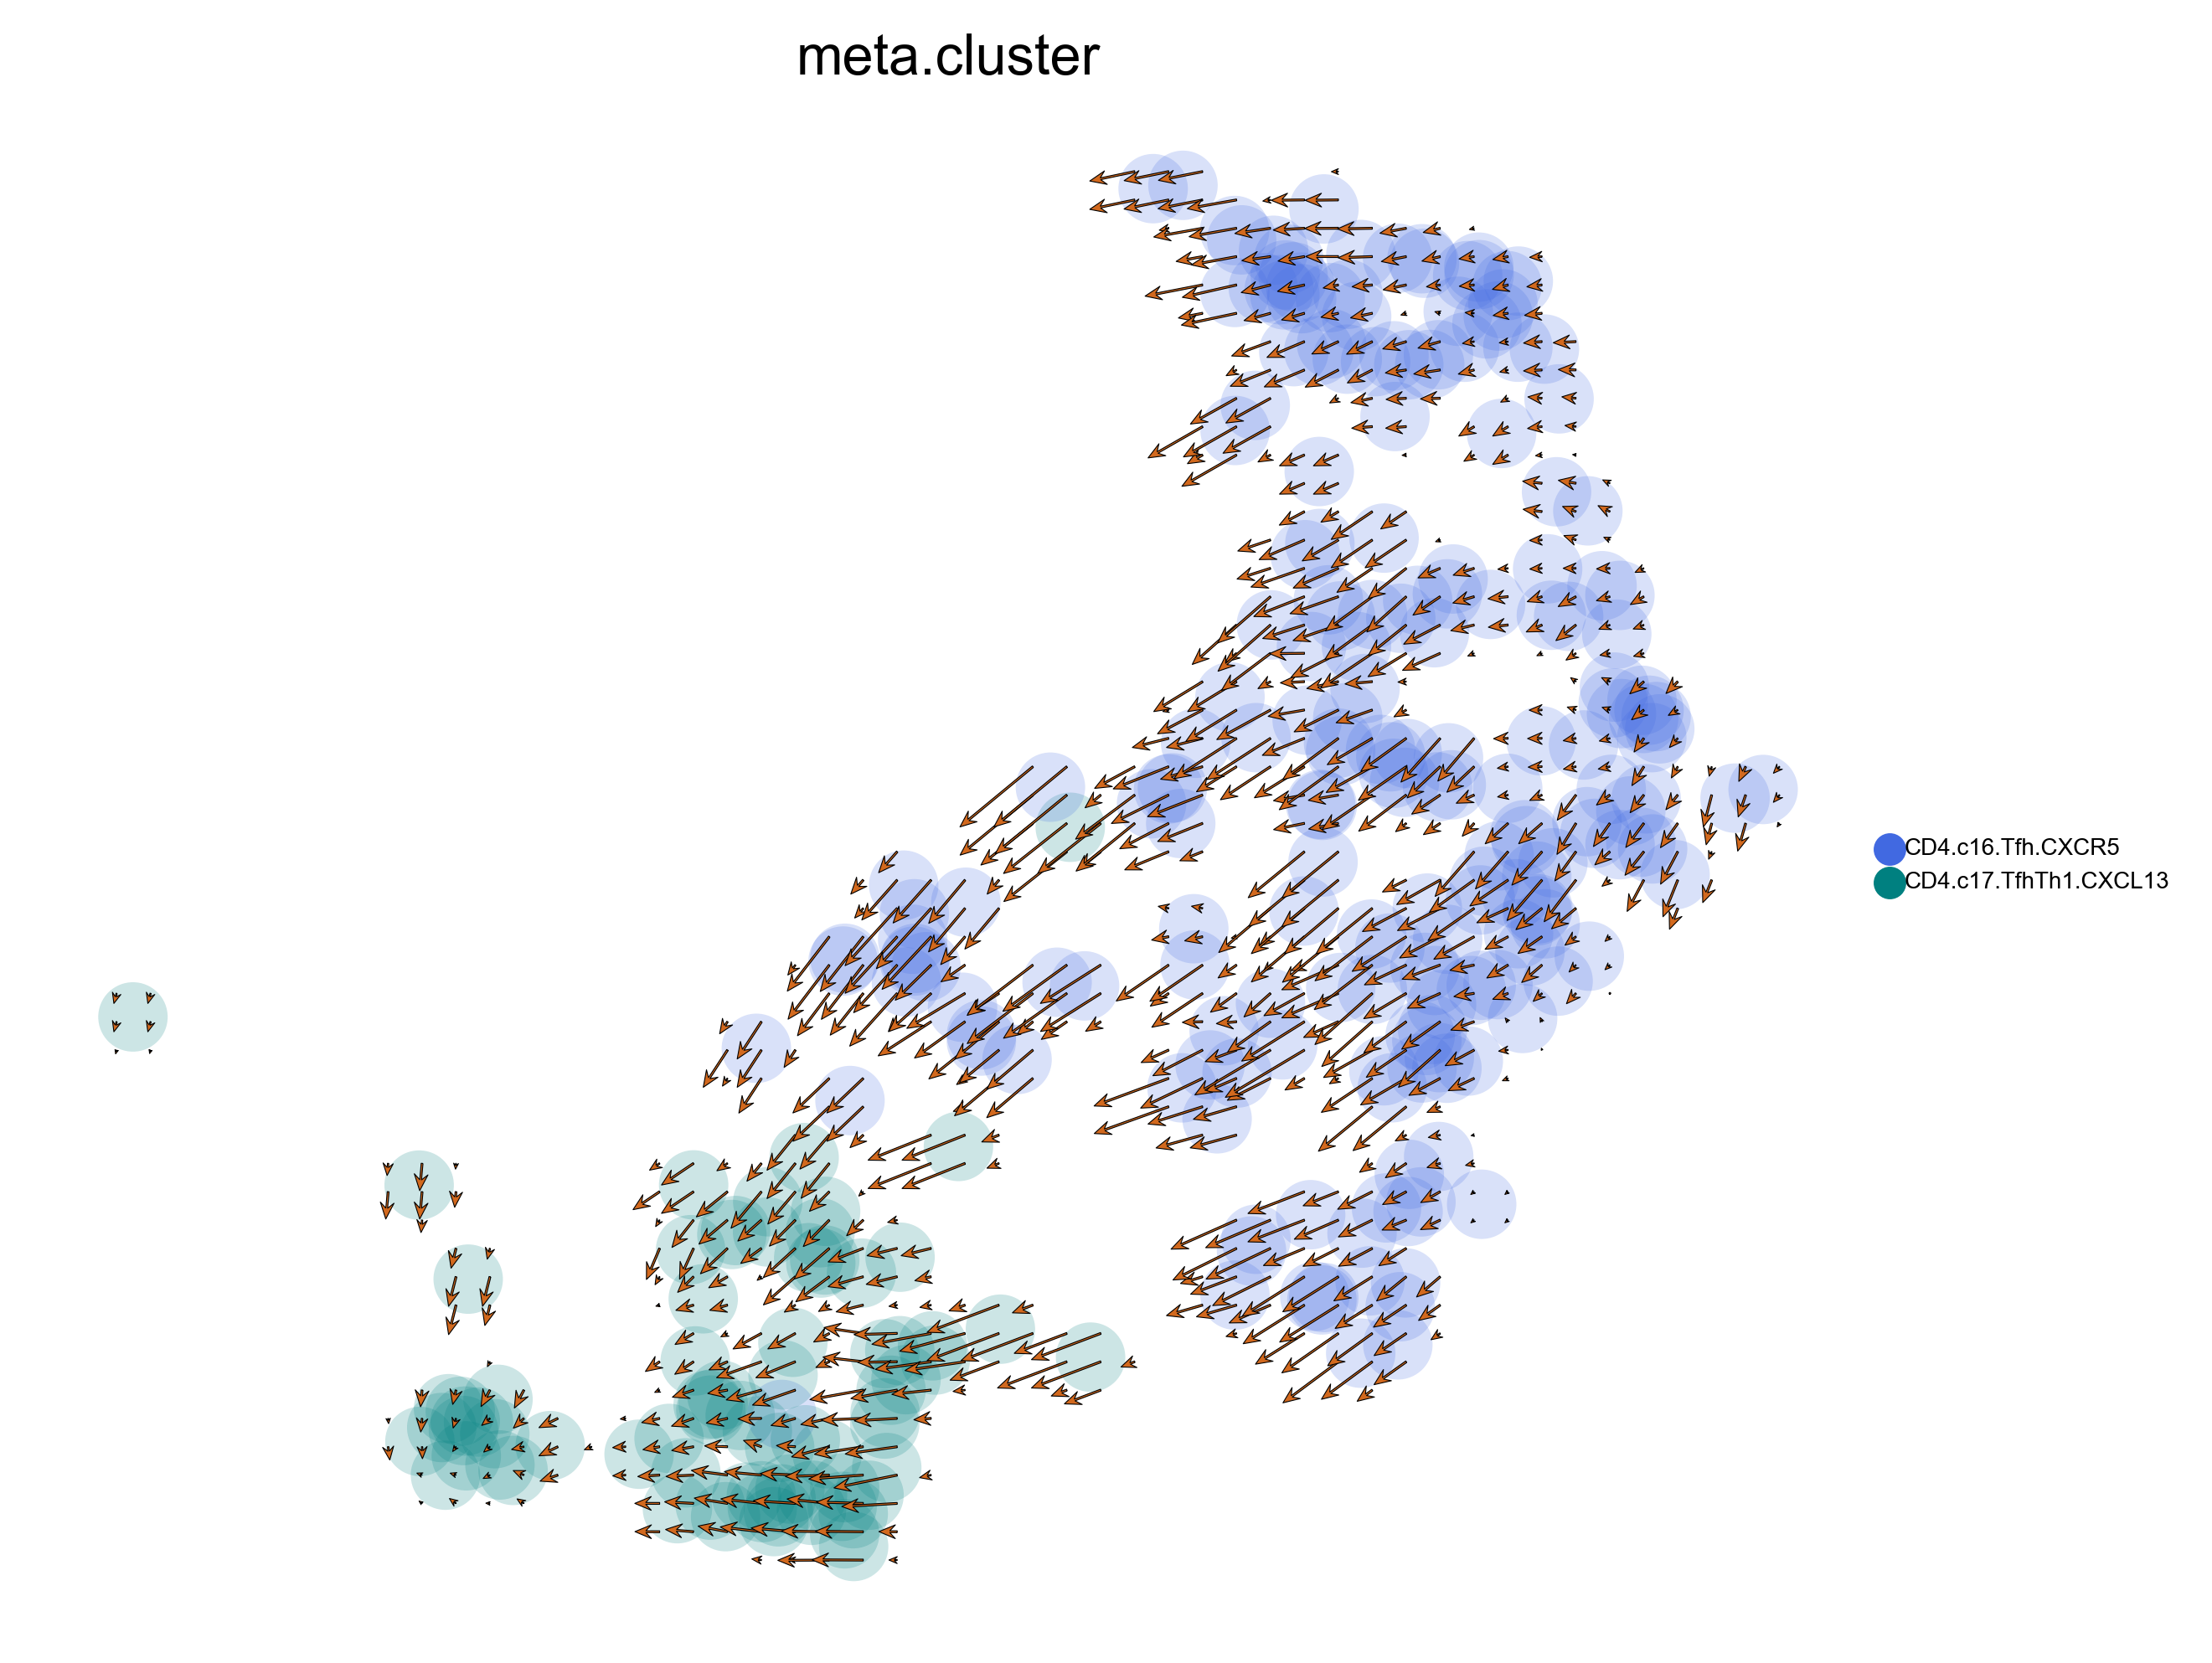

In [14]:
scv.settings.set_figure_params('scvelo', dpi=200)
scv.pl.velocity_embedding_grid(adata, basis='UMAP',color='meta.cluster',arrow_size=1.5, arrow_length=2.5,
                               arrow_color="#D2691E",
                               legend_loc='right margin',legend_fontsize=5,
                               save=f".{stype}_Tfh.FigureS25.umap.pdf", figsize=(7,6))

saving figure to file ./figures/scvelo_.CD4_Tfh.FigureS25.umap_M3pseudotime.pdf


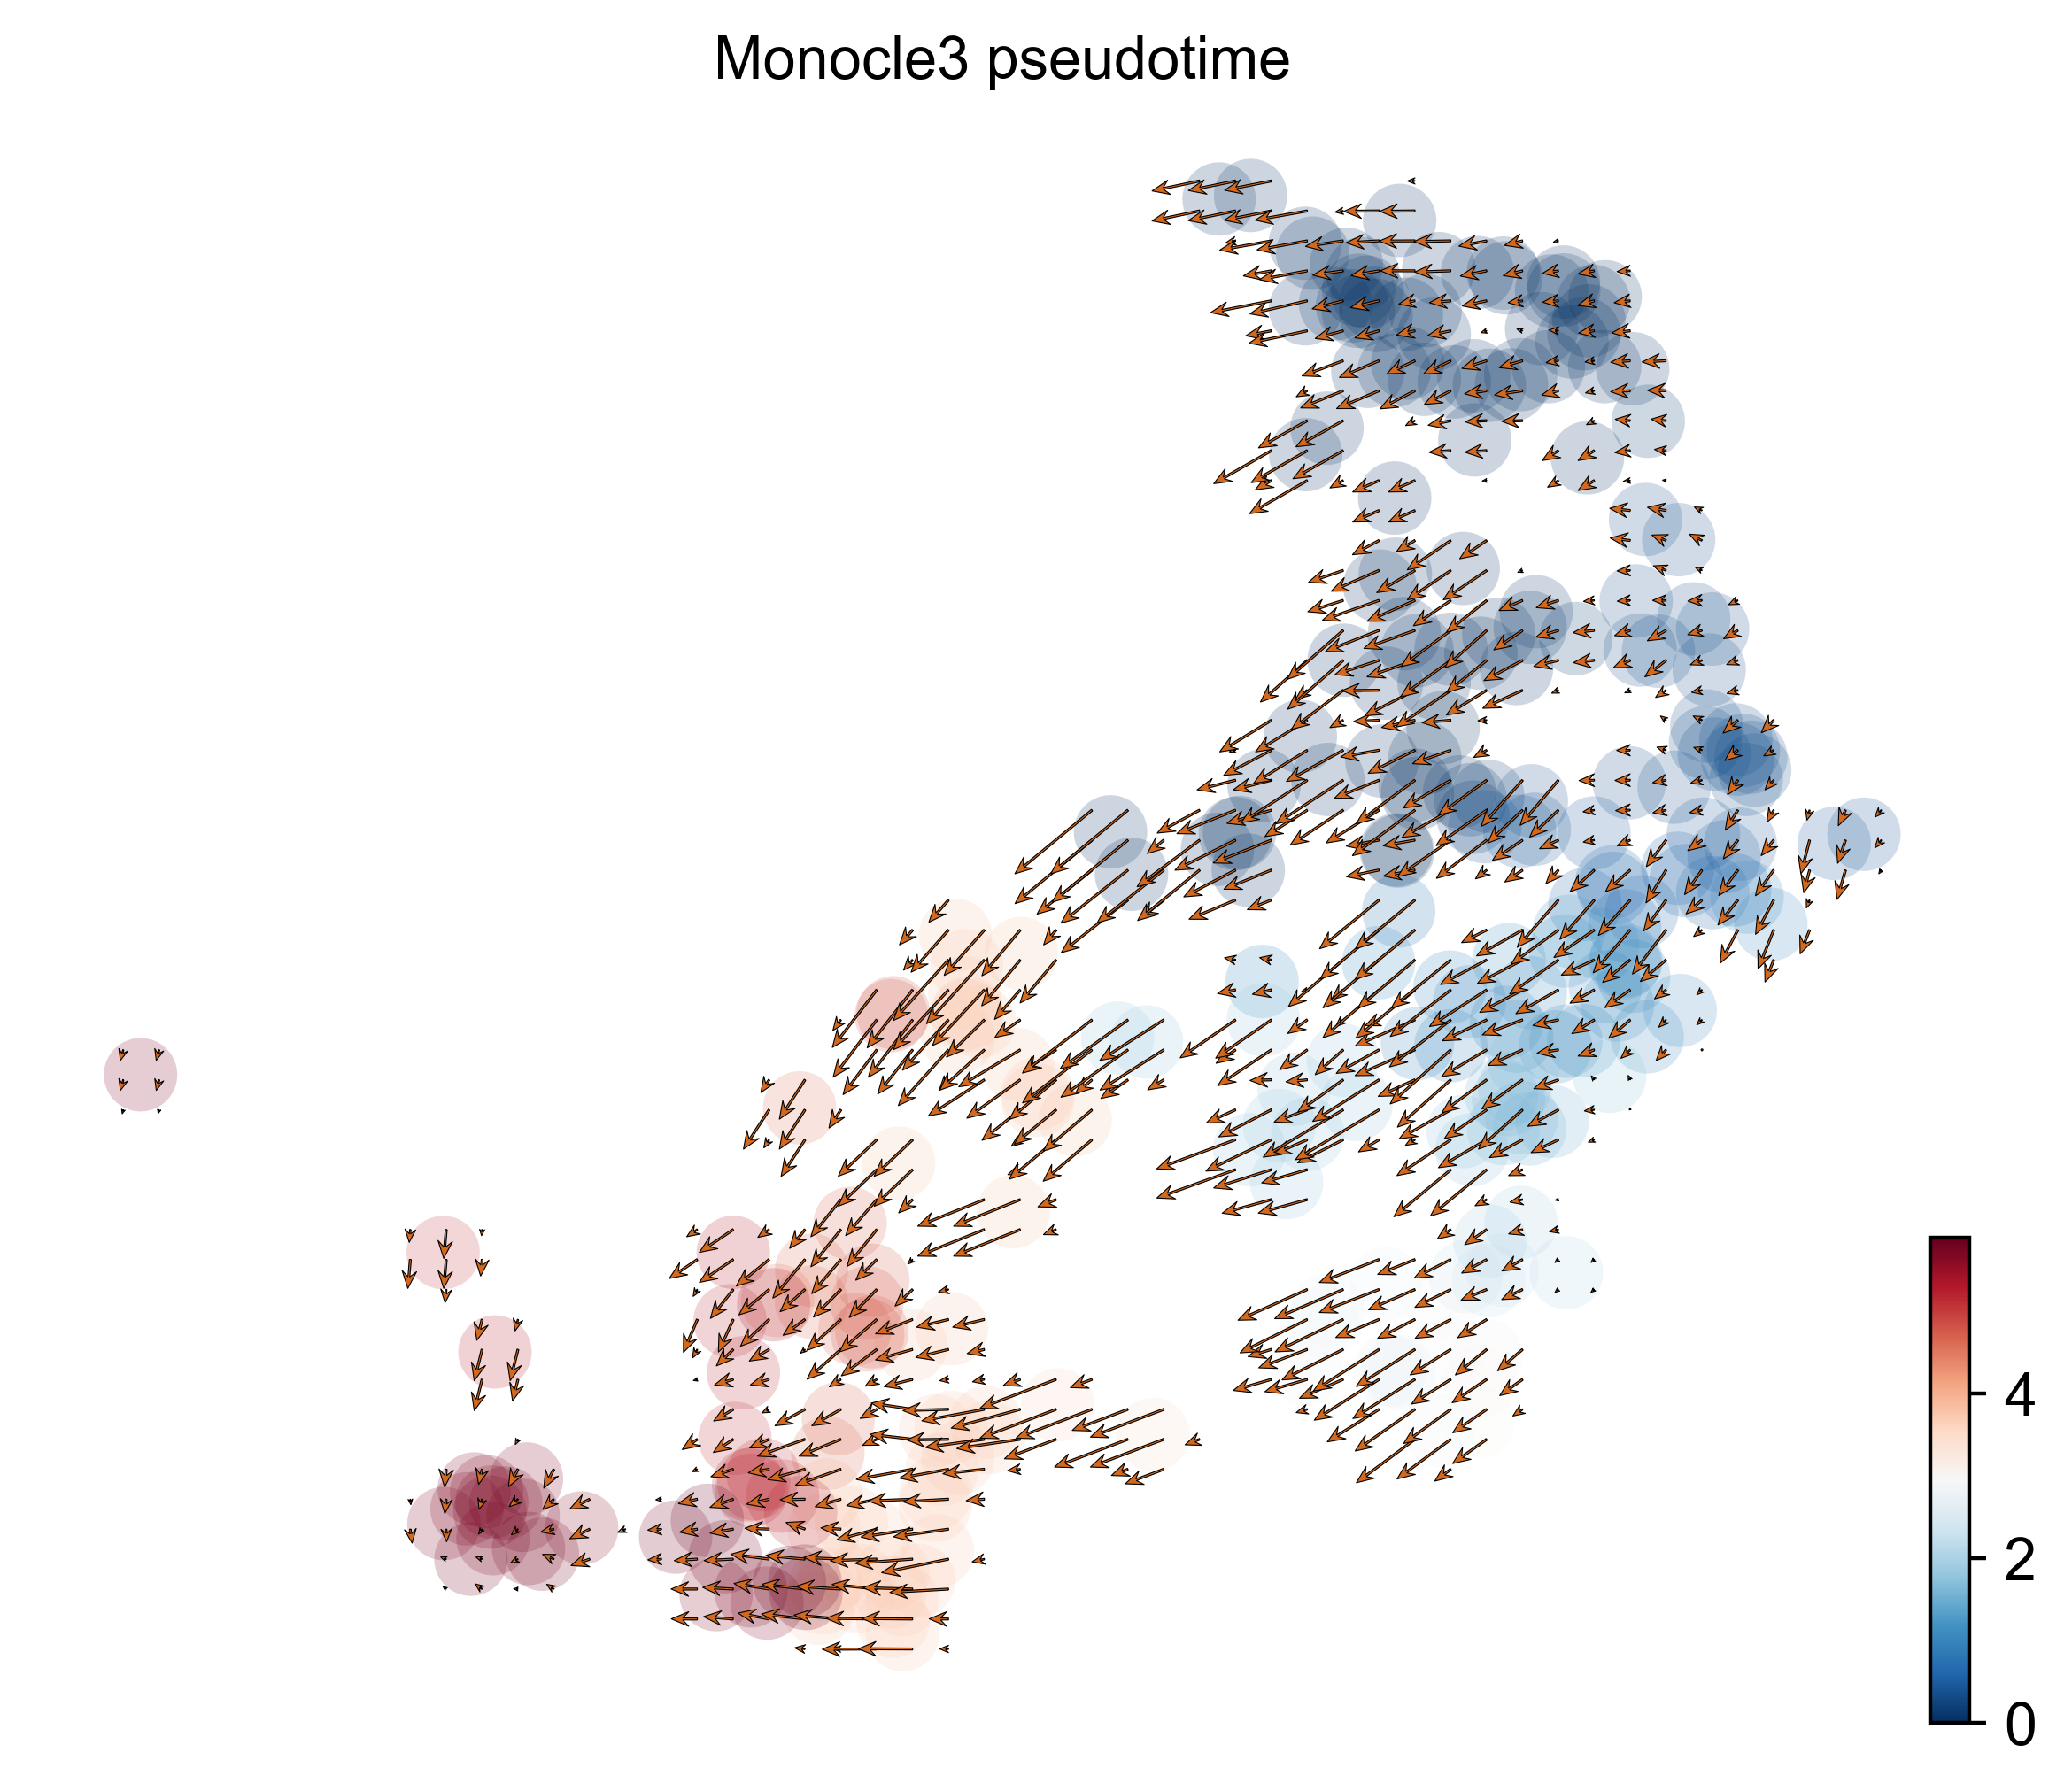

In [15]:
scv.settings.set_figure_params('scvelo', dpi=200)
scv.pl.velocity_embedding_grid(adata, basis='UMAP',color='Monocle3_pseudotime',
                               arrow_size=1.5, arrow_length=2.5,  arrow_color="#D2691E",
                               legend_loc='right margin',legend_fontsize=5,
                               save=f".{stype}_Tfh.FigureS25.umap_M3pseudotime.pdf", figsize=(7,6))

In [16]:
adata.write(f"{oDir}/{stype}_Tfh.velo.h5ad")